In [1]:
# ============================================================
# 00_station_season_build_modelling_dataset.ipynb
# STEP 1 — station × season modelling table (Mafer)
# ============================================================

from pathlib import Path

import numpy as np
import pandas as pd

# --------------------------------------------------------------------
# 0. Paths & config
# --------------------------------------------------------------------

DATA_DIR = Path(r"D:\Polimi\GenHack 2025\Data")   # <- change if needed

# Daily table from your previous script (2020–2023, 12 stations, 18 features)
INPUT_PATH  = DATA_DIR / "outputs" / "stations_daily_with_features.parquet"

# Output: 1 row per station × season with aggregated features
OUTPUT_PATH = DATA_DIR / "outputs" / "station_season_modelling_dataset.parquet"
OUTPUT_CSV  = DATA_DIR / "outputs" / "station_season_modelling_dataset.csv"

# Wind intensity thresholds (in m/s) – easy to tweak
WS_WEAK_MAX  = 2.0   # [0, 2)   → weak wind
WS_MED_MAX   = 6.0   # [2, 6)   → medium wind
# [6, ∞)  → strong wind

# Rainy day threshold (in mm)
RAINY_DAY_MM = 1.0   # a day is "rainy" if precip >= 1 mm


# --------------------------------------------------------------------
# 1. Load daily table
# --------------------------------------------------------------------

print(f"Loading daily table from: {INPUT_PATH}")

if INPUT_PATH.suffix == ".parquet":
    df = pd.read_parquet(INPUT_PATH)
else:
    df = pd.read_csv(INPUT_PATH)

print("Shape daily table:", df.shape)
print("Columns:", df.columns.tolist())

# Ensure date is datetime
if not np.issubdtype(df["date"].dtype, np.datetime64):
    df["date"] = pd.to_datetime(df["date"])

# Quick sanity check of years and seasons
print("Years in data:", sorted(df["date"].dt.year.unique()))
print("Seasons in data:", df["season"].unique())


# --------------------------------------------------------------------
# 2. Helper columns: precip in mm, rainy days, wind intensity class
# --------------------------------------------------------------------

# ERA5 precip is usually in meters → convert to mm
# (If yours is already in mm, comment this line out)
df["precip_mm"] = df["precip"] * 1000.0

# Flag rainy days
df["is_rainy"] = df["precip_mm"] >= RAINY_DAY_MM

# Wind intensity categories based on WS (m/s)
bins   = [0.0, WS_WEAK_MAX, WS_MED_MAX, np.inf]
labels = ["weak", "medium", "strong"]

df["ws_intensity"] = pd.cut(
    df["WS"],
    bins=bins,
    labels=labels,
    right=False,          # [a, b)
    include_lowest=True
)

# NOTE: u10, v10, WS & wind_regime only exist for 2022–2023.
# Pandas .mean() will automatically ignore NaNs, so seasonal means
# are computed on the years where data exist.


# --------------------------------------------------------------------
# 3. Group by station × season and aggregate
# --------------------------------------------------------------------

group_cols = [
    "station_id",
    "name",
    "lat",
    "lon",
    "env_class",
    "season"
]


def summarize_station_season(group: pd.DataFrame) -> pd.Series:
    """
    Build one summary row for a given station × season.

    This follows exactly the STEP 1 spec:
    - target: error_mean_season
    - static features: NDVI_mean, urban_fraction, distance_to_sea_km, latitude (lat)
    - seasonal meteo: WS_mean, wind intensity %, precip_mean, %_rainy_days
    """
    # Static-ish variables: take the average (they are constant per station anyway)
    ndvi_mean        = group["NDVI_mean"].mean()
    urban_fraction   = group["urban_fraction"].mean()
    dist_sea_km      = group["distance_to_sea_km"].mean()

    # Target: mean seasonal bias ERA5 - station
    error_mean_season = group["error"].mean()

    # Seasonal meteorological aggregates
    ws_mean          = group["WS"].mean()
    precip_mean_mm   = group["precip_mm"].mean()

    # Wind intensity percentages
    vc = group["ws_intensity"].value_counts(normalize=True)

    pct_weak   = vc.get("weak",   0.0) * 100.0
    pct_medium = vc.get("medium", 0.0) * 100.0
    pct_strong = vc.get("strong", 0.0) * 100.0

    # Rainy-day frequency
    pct_rainy = group["is_rainy"].mean() * 100.0

    # Number of days contributing to this season (useful as context)
    n_days = group["date"].nunique()

    return pd.Series(
        {
            # Target
            "error_mean_season": error_mean_season,

            # Static features
            "NDVI_mean":          ndvi_mean,
            "urban_fraction":     urban_fraction,
            "distance_to_sea_km": dist_sea_km,
            "latitude":           group["lat"].iloc[0],

            # Seasonal meteo features
            "WS_mean":           ws_mean,
            "precip_mean_mm":    precip_mean_mm,
            "pct_weak_wind":     pct_weak,
            "pct_medium_wind":   pct_medium,
            "pct_strong_wind":   pct_strong,
            "pct_rainy_days":    pct_rainy,

            # Diagnostics
            "n_days":            n_days,
        }
    )


modelling_df = (
    df
    .groupby(group_cols)
    .apply(summarize_station_season)
    .reset_index()
)

print("Modelling dataset shape:", modelling_df.shape)
modelling_df.head()


Loading daily table from: D:\Polimi\GenHack 2025\Data\outputs\stations_daily_with_features.parquet
Shape daily table: (17532, 18)
Columns: ['station_id', 'name', 'lat', 'lon', 'distance_to_sea_km', 'NDVI_mean', 'urban_fraction', 'env_class', 'date', 'season', 'T_station', 'T_ERA5', 'error', 'u10', 'v10', 'WS', 'wind_regime', 'precip']
Years in data: [np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Seasons in data: ['DJF' 'MAM' 'JJA' 'SON']
Modelling dataset shape: (48, 18)


C:\Users\mfmr2\AppData\Local\Temp\ipykernel_3628\2859403461.py:160: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(summarize_station_season)


,station_id,name,lat,lon,env_class,season,error_mean_season,NDVI_mean,urban_fraction,distance_to_sea_km,latitude,WS_mean,precip_mean_mm,pct_weak_wind,pct_medium_wind,pct_strong_wind,pct_rainy_days,n_days
0,16924,CASTEL CELLESI,42.585556,12.160556,rural_interior,DJF,0.568061,0.751874,0.004585,53.938996,42.585556,1.694533,1.511203,66.111111,33.888889,0.000000,25.761773,361.0
1,16924,CASTEL CELLESI,42.585556,12.160556,rural_interior,JJA,-0.048439,0.751874,0.004585,53.938996,42.585556,1.417858,0.806648,77.717391,22.282609,0.000000,15.760870,368.0
2,16924,CASTEL CELLESI,42.585556,12.160556,rural_interior,MAM,0.200524,0.751874,0.004585,53.938996,42.585556,1.679992,1.037764,68.478261,31.521739,0.000000,24.184783,368.0
3,16924,CASTEL CELLESI,42.585556,12.160556,rural_interior,SON,0.648361,0.751874,0.004585,53.938996,42.585556,1.678779,1.827527,69.230769,30.769231,0.000000,29.945055,364.0
4,25857,BATTIPAGLIA,40.584444,14.981389,urban_coastal,DJF,-1.629848,0.000000,0.373410,7.524308,40.584444,2.042449,2.806213,55.555556,41.666667,2.777778,37.950139,361.0


In [3]:
# --------------------------------------------------------------------
# 4. Optional: sort rows and check for NaNs
# --------------------------------------------------------------------

modelling_df = modelling_df.sort_values(
    by=["station_id", "season"]
).reset_index(drop=True)

print("\nNaNs per column:")
print(modelling_df.isna().sum())

# --------------------------------------------------------------------
# 5. Save to Parquet + CSV
# --------------------------------------------------------------------

OUTPUT_PATH.parent.mkdir(parents=True, exist_ok=True)

modelling_df.to_parquet(OUTPUT_PATH, index=False)
modelling_df.to_csv(OUTPUT_CSV, index=False)

print(f"\nSaved modelling dataset to:\n- {OUTPUT_PATH}\n- {OUTPUT_CSV}")



NaNs per column:
station_id            0
name                  0
lat                   0
lon                   0
env_class             0
season                0
error_mean_season     0
NDVI_mean             0
urban_fraction        0
distance_to_sea_km    0
latitude              0
WS_mean               0
precip_mean_mm        0
pct_weak_wind         0
pct_medium_wind       0
pct_strong_wind       0
pct_rainy_days        0
n_days                0
dtype: int64

Saved modelling dataset to:
- D:\Polimi\GenHack 2025\Data\outputs\station_season_modelling_dataset.parquet
- D:\Polimi\GenHack 2025\Data\outputs\station_season_modelling_dataset.csv


In [4]:
# --------------------------------------------------------------------
# 6. Summary table for the report (12 × 4 = 48 rows)
# --------------------------------------------------------------------

summary_cols = [
    "station_id",
    "name",
    "env_class",
    "season",
    "error_mean_season",
    "NDVI_mean",
    "urban_fraction",
    "distance_to_sea_km",
    "WS_mean",
    "precip_mean_mm",
    "pct_rainy_days",
    "n_days",
]

summary_df = modelling_df[summary_cols].copy()

# Round for readability in slides / PDF
round_dict = {
    "error_mean_season": 2,
    "NDVI_mean": 3,
    "urban_fraction": 3,
    "distance_to_sea_km": 1,
    "WS_mean": 2,
    "precip_mean_mm": 1,
    "pct_rainy_days": 1,
}

for col, ndig in round_dict.items():
    summary_df[col] = summary_df[col].round(ndig)

print("\n=== Station × season summary table (for report) ===")
print(summary_df.to_string(index=False))

# Optional: export a CSV you can drop into LaTeX / PowerPoint
SUMMARY_CSV = DATA_DIR / "outputs" / "station_season_summary_for_report.csv"
summary_df.to_csv(SUMMARY_CSV, index=False)
print(f"\nSummary table saved to: {SUMMARY_CSV}")



=== Station × season summary table (for report) ===
station_id                name      env_class season  error_mean_season  NDVI_mean  urban_fraction  distance_to_sea_km  WS_mean  precip_mean_mm  pct_rainy_days  n_days
     16924      CASTEL CELLESI rural_interior    DJF               0.57      0.752           0.005                53.9     1.69             1.5            25.8   361.0
     16924      CASTEL CELLESI rural_interior    JJA              -0.05      0.752           0.005                53.9     1.42             0.8            15.8   368.0
     16924      CASTEL CELLESI rural_interior    MAM               0.20      0.752           0.005                53.9     1.68             1.0            24.2   368.0
     16924      CASTEL CELLESI rural_interior    SON               0.65      0.752           0.005                53.9     1.68             1.8            29.9   364.0
     25857         BATTIPAGLIA  urban_coastal    DJF              -1.63      0.000           0.373         

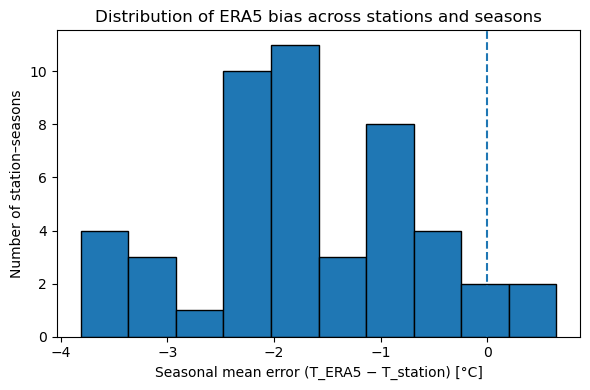

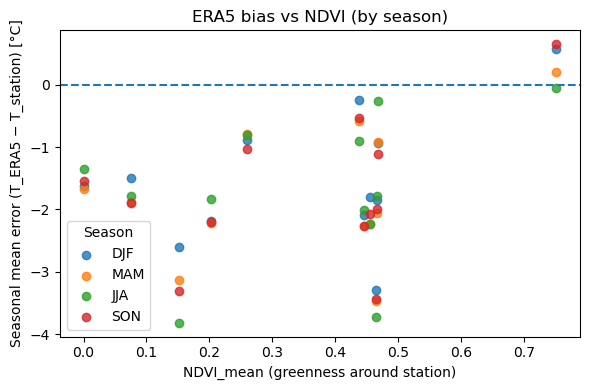

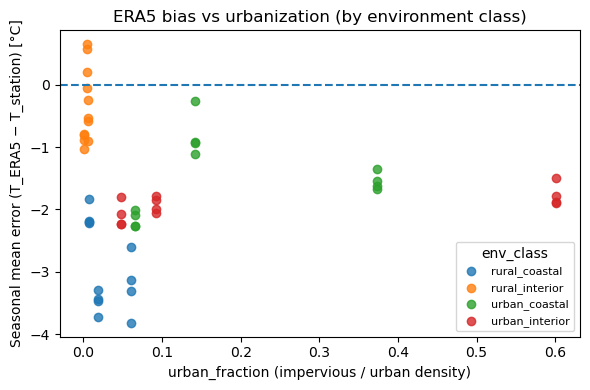

In [5]:
# --------------------------------------------------------------------
# 7. Sanity-check plots (for Mafer + ISA)
# --------------------------------------------------------------------

import matplotlib.pyplot as plt

plt.style.use("default")

# ---------- 7.1 Histogram of seasonal bias ----------
plt.figure(figsize=(6, 4))
plt.hist(modelling_df["error_mean_season"], bins=10, edgecolor="black")
plt.axvline(0, linestyle="--")
plt.xlabel("Seasonal mean error (T_ERA5 − T_station) [°C]")
plt.ylabel("Number of station–seasons")
plt.title("Distribution of ERA5 bias across stations and seasons")
plt.tight_layout()
plt.show()

# ---------- 7.2 Scatter: error vs NDVI ----------
plt.figure(figsize=(6, 4))

for season in ["DJF", "MAM", "JJA", "SON"]:
    sub = modelling_df[modelling_df["season"] == season]
    plt.scatter(
        sub["NDVI_mean"],
        sub["error_mean_season"],
        label=season,
        alpha=0.8,
    )

plt.axhline(0, linestyle="--")
plt.xlabel("NDVI_mean (greenness around station)")
plt.ylabel("Seasonal mean error (T_ERA5 − T_station) [°C]")
plt.title("ERA5 bias vs NDVI (by season)")
plt.legend(title="Season")
plt.tight_layout()
plt.show()

# ---------- 7.3 Scatter: error vs urban_fraction ----------
plt.figure(figsize=(6, 4))

for env in sorted(modelling_df["env_class"].unique()):
    sub = modelling_df[modelling_df["env_class"] == env]
    plt.scatter(
        sub["urban_fraction"],
        sub["error_mean_season"],
        label=env,
        alpha=0.8,
    )

plt.axhline(0, linestyle="--")
plt.xlabel("urban_fraction (impervious / urban density)")
plt.ylabel("Seasonal mean error (T_ERA5 − T_station) [°C]")
plt.title("ERA5 bias vs urbanization (by environment class)")
plt.legend(title="env_class", fontsize=8)
plt.tight_layout()
plt.show()
